In [1]:
#PySpark Dynamodb fetch "FindMyMovie" personality records.
try:
    spark.stop()
except:
    print("No Session")
#Starting PySpark Session
from pyspark.sql import SparkSession

spark=SparkSession.builder.appName('RS')\
    .master("spark://192.168.1.100:7077") \
    .config('spark.executor.memory','4600m') \
    .getOrCreate()   

#Required imports other than SPARK main
import csv
import json
import numpy as np
from pyspark.sql.functions import udf
from pyspark import SparkContext
from pyspark.sql.types import StringType ,IntegerType

In [31]:
#Importing Segregation logic by introducing K-Means Clustering!
df_K=spark.read.csv('/root/datasets/FYP/O/agg/all_scores.csv',inferSchema=True,header=True)
print((df_K.count(), len(df_K.columns)))
df_K.printSchema()

(1926, 6)
root
 |-- userID: string (nullable = true)
 |-- EXT: integer (nullable = true)
 |-- AGG: integer (nullable = true)
 |-- CON: integer (nullable = true)
 |-- NEU: integer (nullable = true)
 |-- OPN: integer (nullable = true)



In [32]:
#Mapping Features to spark vector assembler.
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

vec = ['EXT', 'AGG', 'CON', 'NEU','OPN']
vec_assembler = VectorAssembler(inputCols = vec,outputCol='features')
opt = vec_assembler.transform(df_K)
opt.cache()


DataFrame[userID: string, EXT: int, AGG: int, CON: int, NEU: int, OPN: int, features: vector]

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [34]:
k = 2
for k in range (2,7):
    print('Clusters ',k)
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(opt)

    # Make predictions
    predictions = model.transform(opt)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)
    print('\n')
    k = k + 1

Clusters  2
Silhouette with squared euclidean distance = 0.3000277371879069
Cluster Centers: 
[78.77754892 62.90422245 46.31822863 65.8661174  67.59217302]
[72.4513089  57.78219895 46.06492147 66.13298429 32.68900524]


Clusters  3
Silhouette with squared euclidean distance = 0.2961942627197221
Cluster Centers: 
[70.82034976 55.0190779  55.69475358 59.78537361 31.51033386]
[76.17161716 61.4669967  58.46039604 59.7310231  68.98184818]
[79.56295224 64.2633864  26.78437048 77.15050651 50.97973951]


Clusters  4
Silhouette with squared euclidean distance = 0.28511763967206716
Cluster Centers: 
[74.64027149 61.50678733 64.88235294 64.08597285 67.98868778]
[71.38030888 60.23552124 32.88223938 77.77606178 32.96911197]
[74.06471816 54.93319415 60.55114823 51.97703549 34.75156576]
[82.63039014 64.80698152 29.26488706 68.99794661 67.91581109]


Clusters  5
Silhouette with squared euclidean distance = 0.274046182529419
Cluster Centers: 
[70.86031746 49.24126984 54.2952381  80.13015873 35.84126984

In [167]:
k = 3
print('Clusters ',k)
# Trains a k-means model.
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(opt)

# Make predictions
predictions = model.transform(opt)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
print('\n')

Clusters  3
Silhouette with squared euclidean distance = 0.2961942627197221
Cluster Centers: 
[70.82034976 55.0190779  55.69475358 59.78537361 31.51033386]
[76.17161716 61.4669967  58.46039604 59.7310231  68.98184818]
[79.56295224 64.2633864  26.78437048 77.15050651 50.97973951]




In [196]:
stats=opt.agg(avg("EXT"),avg("AGG"),avg("CON"),avg("NEU"),avg("OPN") ).collect()
opt.agg(avg("EXT"),avg("AGG"),avg("CON"),avg("NEU"),avg("OPN") ).show()

avg_ext = stats[0][0]
avg_opn = stats[0][1]
avg_con = stats[0][2]
avg_agg = stats[0][3]
avg_neu = stats[0][4]

+-----------------+-----------------+------------------+-----------------+------------------+
|         avg(EXT)|         avg(AGG)|          avg(CON)|         avg(NEU)|          avg(OPN)|
+-----------------+-----------------+------------------+-----------------+------------------+
|75.64070612668743|60.36448598130841|46.192627206645895|65.99844236760124|50.285565939771544|
+-----------------+-----------------+------------------+-----------------+------------------+



In [168]:
from pyspark.ml.linalg import Vectors
vr = Vectors.dense([90.0, 90.0, 20.0,90.2,60.0])
model.predict(vr)

2

In [133]:
predictions.tail(10)

[Row(userID='05c3cb1b8a8178cede7f670072ae074c', EXT=71, AGG=35, CON=14, NEU=85, OPN=28, features=DenseVector([71.0, 35.0, 14.0, 85.0, 28.0]), prediction=1),
 Row(userID='8d97cf10d1b93ed2309d00749dff1bde', EXT=78, AGG=71, CON=42, NEU=64, OPN=35, features=DenseVector([78.0, 71.0, 42.0, 64.0, 35.0]), prediction=1),
 Row(userID='a93c70e19a3472093e8216ef5d9a6746', EXT=85, AGG=85, CON=28, NEU=71, OPN=85, features=DenseVector([85.0, 85.0, 28.0, 71.0, 85.0]), prediction=3),
 Row(userID='ff8b293ae258fe516c39acecb966dba4', EXT=64, AGG=78, CON=14, NEU=78, OPN=28, features=DenseVector([64.0, 78.0, 14.0, 78.0, 28.0]), prediction=1),
 Row(userID='15ea063907f4e038ed6465286e6804b4', EXT=71, AGG=57, CON=57, NEU=50, OPN=42, features=DenseVector([71.0, 57.0, 57.0, 50.0, 42.0]), prediction=2),
 Row(userID='cff910b71f09b3120289ff6b461a9e03', EXT=78, AGG=50, CON=71, NEU=57, OPN=78, features=DenseVector([78.0, 50.0, 71.0, 57.0, 78.0]), prediction=0),
 Row(userID='1ab3a4c2921d8da640854819b0f6cfce', EXT=57, AG

In [169]:
temp=predictions.groupBy("prediction").count()
temp.orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  628|
|         1|  606|
|         2|  692|
+----------+-----+



In [188]:
main = predictions.withColumn("prediction", predictions["prediction"].cast("string"))
c_0 = main.filter(main.prediction == '0')
c_0 = c_0.select('userID','prediction')
c_1= main.filter(main.prediction == '1')
c_1 = c_1.select('userID','prediction')
c_2 = main.filter(main.prediction == '2')
c_2 = c_2.select('userID','prediction')


In [193]:
c_0.show(2)

#Saving Clusters
c_0 \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/c_0")

c_1 \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/c_1")

c_2 \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/c_2")



+--------------------+----------+
|              userID|prediction|
+--------------------+----------+
|b7e8a92987a530cc3...|         0|
|030001ac2145a938b...|         0|
+--------------------+----------+
only showing top 2 rows



In [170]:
predictions.groupBy("prediction").agg(avg("EXT"),avg("AGG"),avg("CON"),avg("NEU"),avg("OPN") ).orderBy("prediction").show(10)

+----------+-----------------+------------------+------------------+------------------+------------------+
|prediction|         avg(EXT)|          avg(AGG)|          avg(CON)|          avg(NEU)|          avg(OPN)|
+----------+-----------------+------------------+------------------+------------------+------------------+
|         0|70.84235668789809|55.017515923566876|55.968152866242036|59.605095541401276|31.644904458598727|
|         1|76.18316831683168|61.585808580858085| 58.26897689768977| 59.95544554455446| 69.16666666666667|
|         2|79.52023121387283| 64.14739884393063|26.745664739884393| 77.09248554913295| 50.66763005780347|
+----------+-----------------+------------------+------------------+------------------+------------------+



In [3]:
#Spark ALS Mod
df=spark.read.csv('/root/datasets/FYP/O/agg/ratings/*.csv',inferSchema=True,header=True)
#df = df.na.drop(subset=["titleID"])
df = df.drop('r_type')


df_save = df.select('userID').distinct()
df_save = df_save.rdd
df_save = df_save.zipWithIndex()
df_save = df_save.toDF()
df_save = df_save.withColumn("_2", df_save["_2"].cast("integer"))
df_save = df_save.withColumn("_1", df_save["_1"].cast("string"))

def rem(x):
    return x[1:-1]


setter=udf(rem,StringType())
df_lay = df_save.withColumn('_1',setter(df_save._1))

df_lay \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/string")





In [4]:

#Creating a lookup for movieID to TMDB movie ID.
#Loading reference file and storing it as a python dict obj
with open('/root/datasets/FYP/O/agg/string.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

        
        

def get_ID(x):
    a = mydict[x]
    return a

get=udf(get_ID,StringType())
df_ = df.withColumn('userIDint',get(df.userID))
df_ = df_.withColumn("userIDint", df_["userIDint"].cast("integer"))
df_ \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/ratingsmod")

In [41]:
#mydict
df.count()

1026715

In [35]:
#ALS refined dataset
dfd=spark.read.csv('/root/datasets/FYP/O/agg/ratingsmod/*.csv',inferSchema=True,header=True)
dfd.show(5)

+--------------------+-------+------+---------+
|              userID|titleID|rating|userIDint|
+--------------------+-------+------+---------+
|8e7cebf9a234c064b...|    862|    10|      731|
|8e7cebf9a234c064b...|   8844|     8|      731|
|8e7cebf9a234c064b...|  15602|     8|      731|
|8e7cebf9a234c064b...|  11862|    10|      731|
|8e7cebf9a234c064b...|    949|     8|      731|
+--------------------+-------+------+---------+
only showing top 5 rows



In [3]:
dfd.summary

<bound method DataFrame.summary of DataFrame[userID: string, titleID: int, rating: int, userIDint: int]>

In [15]:
(training, test) = dfd.randomSplit([0.8, 0.2])
training.cache()

DataFrame[userID: string, titleID: int, rating: int, userIDint: int]

In [47]:
# Load and parse the data
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql import Row
it = 0
rmse=[]
k = [[10,10,1],[25,15,0.01],[5,5,1],[15,25,1],[5,25,0.001]]
for x in k:
    # Build the recommendation model using ALS on the training data
    als = ALS(rank=x[0],maxIter=x[1], regParam=x[2], userCol="userIDint", itemCol="titleID", ratingCol="rating")
    model = als.fit(training)

    # Evaluate the model by computing the RMSE on the test data
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse.append( evaluator.evaluate(predictions))
    it = it + 1

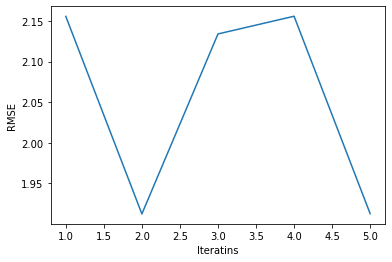

In [7]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4,5], rmse)
plt.ylabel('RMSE')
plt.xlabel('Iteratins')

plt.show()

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
# Build the recommendation model using ALS on the training data
als = ALS(rank=10,maxIter=20, regParam=0.1, userCol="userIDint", itemCol="titleID", ratingCol="rating",coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print("RMSE = " + str(rmse))


RMSE = 1.6579999544


In [88]:
#ALSModel.save("/root/datasets/FYP/O/agg/models/main")

In [53]:

model = ALSModel.load("/root/datasets/FYP/O/agg/models/main")

In [18]:
predictions.show(20)

+--------------------+-------+------+---------+----------+
|              userID|titleID|rating|userIDint|prediction|
+--------------------+-------+------+---------+----------+
|b54372490fb6e3cca...|    148|     2|      332| 2.5166857|
|7ffab5e3c02484685...|    148|     4|     1059| 6.4699097|
|0f741cad145cb26ec...|    148|     6|      922| 6.2236276|
|c7da3af93e28b6083...|    148|     8|       69| 7.6961346|
|13c4e10a9e5409b8a...|    496|     8|     1342|  7.044288|
|f7c8ab67deafad75f...|    496|     6|     1084| 5.4470043|
|46ea756aec37d8e06...|    496|     8|     1322|  8.113064|
|318b8b8173dbe0882...|    496|     8|      458|  5.900587|
|872232ae22400781c...|    496|     2|      472|  4.430376|
|46286f683f8cb3eb7...|    496|     6|      211| 3.9567454|
|b6648870eb61ee8a7...|    496|    10|     1051|  5.683789|
|09c249d552a0a3fab...|    496|     2|      412|  5.071378|
|9d2edc56b4025427f...|    496|     6|     1030|  5.627977|
|e8525624725a0bed6...|    496|     6|     1752|   5.4114

In [11]:
predictions.orderBy(("rating").asc())

AttributeError: 'str' object has no attribute 'asc'

In [30]:
get=model.recommendForAllUsers(10)

In [36]:
store=get.select('userIDint','recommendations.titleID')

In [38]:
store.show(2)

+---------+--------------------+
|userIDint|             titleID|
+---------+--------------------+
|     1580|[473984, 44992, 1...|
|      471|[41504, 81365, 14...|
+---------+--------------------+
only showing top 2 rows



In [40]:
store = store.withColumn("titleID", store["titleID"].cast("string"))


In [42]:
store \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/prerat")

In [40]:
#Add Clusters
with open('/root/datasets/FYP/O/agg/clusters.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

        

def get_ID(x):
    a = mydict.get(x,'0')
    return a

get=udf(get_ID,StringType())
df_0 = dfd.withColumn('cluster',get(dfd.userID))
        


In [41]:
df_0.summary

<bound method DataFrame.summary of DataFrame[userID: string, titleID: int, rating: int, userIDint: int, cluster: string]>

In [42]:
df_0.count()

1026715

In [43]:
df_0.select('userIDint','titleID','rating').filter('cluster == 0').count()

389317

In [44]:
c_0 = df_0.filter(df_0.cluster == '0')
c_1= df_0.filter(df_0.cluster == '1')
c_2 = df_0.filter(df_0.cluster == '2')


In [47]:
c_2.count()

382696

In [55]:
(train0, test0) = c_0.randomSplit([0.8, 0.2])
(train1, test1) = c_1.randomSplit([0.8, 0.2])
(train2, test2) = c_2.randomSplit([0.8, 0.2])
train0.cache()


DataFrame[userID: string, titleID: int, rating: int, userIDint: int, cluster: string]

In [67]:

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
# Build the recommendation model using ALS on the training data
als = ALS(rank=10,maxIter=10, regParam=0.1, userCol="userIDint", itemCol="titleID", ratingCol="rating",coldStartStrategy="drop")
model = als.fit(train0)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test0)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print('RMSE = ',str(rmse))


RMSE =  1.8136221989302894


In [69]:
get=model.recommendForAllUsers(10)
store=get.select('userIDint','recommendations.titleID')
store = store.withColumn("titleID", store["titleID"].cast("string"))
store \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/c0")

In [70]:
train1.cache()

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
# Build the recommendation model using ALS on the training data
als = ALS(rank=10,maxIter=10, regParam=0.1, userCol="userIDint", itemCol="titleID", ratingCol="rating",coldStartStrategy="drop")
model = als.fit(train1)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test1)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print('RMSE = ',str(rmse))


RMSE =  1.7896245995686275


In [71]:
get=model.recommendForAllUsers(10)
store=get.select('userIDint','recommendations.titleID')
store = store.withColumn("titleID", store["titleID"].cast("string"))
store \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/c1")

In [72]:
train2.cache()

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
# Build the recommendation model using ALS on the training data
als = ALS(rank=10,maxIter=10, regParam=0.1, userCol="userIDint", itemCol="titleID", ratingCol="rating",coldStartStrategy="drop")
model = als.fit(train2)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test2)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print('RMSE = ',str(rmse))


RMSE =  1.7324192559667495


In [73]:
get=model.recommendForAllUsers(10)
store=get.select('userIDint','recommendations.titleID')
store = store.withColumn("titleID", store["titleID"].cast("string"))
store \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/c2")

In [83]:
#FINALLLLLLLLLLY 

#Creating a lookup for movieID to TMDB movie ID.
#Loading reference file and storing it as a python dict obj
with open('/root/datasets/FYP/O/agg/string.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[1]:rows[0] for rows in reader}

        

In [82]:
frame = spark.read.csv('/root/datasets/FYP/O/agg/recommendations.csv',inferSchema=True,header=True)


In [86]:
def get_ID(x):
    x = str(x)
    a = mydict[x]
    return a

get=udf(get_ID,StringType())
df_ = frame.withColumn('userID',get(frame.userIDint))
df_.show(2)

+---------+--------------------+--------------------+
|userIDint|             titleID|              userID|
+---------+--------------------+--------------------+
|     1580|[189227, 513434, ...|4cf755cd3340dcd26...|
|      463|[209415, 92060, 3...|9506c5c93356b984b...|
+---------+--------------------+--------------------+
only showing top 2 rows



<bound method DataFrame.summary of DataFrame[userIDint: int, titleID: string, userID: string]>

In [91]:
#Creating a lookup for movieID to TMDB movie ID.
#Loading reference file and storing it as a python dict obj
with open('/root/datasets/FYP/email_userID_ref.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

In [93]:
def get_ID(x):
    a = mydict.get(x,'0')
    return a

get=udf(get_ID,StringType())
df_final = df_.withColumn('email',get(df_.userID))


+---------+--------------------+--------------------+
|userIDint|             titleID|              userID|
+---------+--------------------+--------------------+
|     1580|[189227, 513434, ...|4cf755cd3340dcd26...|
|      463|[209415, 92060, 3...|9506c5c93356b984b...|
+---------+--------------------+--------------------+
only showing top 2 rows



In [94]:
df_final.show(2)

+---------+--------------------+--------------------+-----+
|userIDint|             titleID|              userID|email|
+---------+--------------------+--------------------+-----+
|     1580|[189227, 513434, ...|4cf755cd3340dcd26...|    0|
|      463|[209415, 92060, 3...|9506c5c93356b984b...|    0|
+---------+--------------------+--------------------+-----+
only showing top 2 rows



In [103]:
df_rec = df_final.filter(df_final.email != "0")

In [104]:
df_rec.show()

+---------+--------------------+--------------------+--------------------+
|userIDint|             titleID|              userID|               email|
+---------+--------------------+--------------------+--------------------+
|     1721|[31602, 52780, 31...|bcf0c0d5-507a-405...|sales.riqba@gmail...|
|      322|[116368, 299534, ...|8accd167-aa18-401...|syedaiqrafatima22...|
|     1510|[44065, 25117, 40...|0b1ea2fd-d500-4b1...|Diamond.eyes599@g...|
|     1489|[31602, 43774, 40...|36ad85f2-9642-471...|ahmedtahami@yahoo...|
|      388|[189227, 14733, 1...|856ec5ce-218a-465...|arslaan.khan188@y...|
|     1516|[189227, 26397, 2...|0332d4f4-b7fe-441...|wayahot322@ffeast...|
|        6|[524047, 36056, 1...|a13eac83-399c-41f...| hamza.edu@yahoo.com|
|       40|[14733, 92060, 26...|7de3db8e-673f-4b3...|manahilj0800@gmai...|
|     1670|[758271, 12616, 1...|ad9c8e13-55a4-48c...|hammad.bhatti187@...|
|        5|[31602, 189227, 2...|b267b427-551b-429...|saad_mir93@hotmai...|
|     1271|[15383, 14733,

In [105]:
columns_to_drop = ['userIDint', 'userID']
df_rec = df_rec.drop(*columns_to_drop)

In [110]:
df_rec.show()
df_rec \
   .repartition(1) \
   .write.format("com.databricks.spark.csv") \
   .option("header", "true")  \
   .save("/root/datasets/FYP/O/agg/final")

+--------------------+--------------------+
|             titleID|               email|
+--------------------+--------------------+
|[31602, 52780, 31...|sales.riqba@gmail...|
|[116368, 299534, ...|syedaiqrafatima22...|
|[44065, 25117, 40...|Diamond.eyes599@g...|
|[31602, 43774, 40...|ahmedtahami@yahoo...|
|[189227, 14733, 1...|arslaan.khan188@y...|
|[189227, 26397, 2...|wayahot322@ffeast...|
|[524047, 36056, 1...| hamza.edu@yahoo.com|
|[14733, 92060, 26...|manahilj0800@gmai...|
|[758271, 12616, 1...|hammad.bhatti187@...|
|[31602, 189227, 2...|saad_mir93@hotmai...|
|[15383, 14733, 92...|     ammar@gmail.com|
|[31602, 43774, 52...|    123456@gmail.com|
|[441909, 24106, 1...|mianabubakar13199...|
|[34038, 293950, 1...|17011065025@umt.e...|
|[299534, 116368, ...|abdulqadirgillani...|
|[299534, 116368, ...|helloshehzad@gmai...|
|[42314, 12169, 41...|talha.cheema8@gma...|
|[44065, 12169, 46...|salmanarif333@gma...|
|[30238, 341174, 4...|  razad431@gmail.com|
|[189227, 758271, ...|talhamerza

In [111]:
#Creating a lookup for movieID to TMDB movie ID.
#Loading reference file and storing it as a python dict obj
with open('/root/datasets/FYP/O/agg/dynamodb_push.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[1]:rows[0] for rows in reader}

In [115]:
li = mydict['sales.riqba@gmail.com']

'31602, 52780, 3173, 40440, 25117, 47447, 60843, 46230, 1481, 28971'

'[31602, 52780, 3173, 40440, 25117, 47447, 60843, 46230, 1481, 28971]'

'31602'

In [138]:
for x in mydict:
    li =mydict[x]
    li = li[1:-1]
    result = [x.strip() for x in li.split(',')]
    mydict[x] = result
    del li
    del result

In [157]:
#Pull Date Dec 2 1030 AM

#Dynamodb Handeler to connect to "FindMyMovie" table.
import boto3
from boto3.dynamodb.conditions import Key, Attr
from botocore.exceptions import ClientError
import botocore


class   dynamodb_FindMyMovies():
    def __init__(self):
        # Get the service resource.
        self.dynamodb = ''#boto3.resource('dynamodb',endpoint_url='http://localhost:8000')
        self.table = ''#dynamodb.Table('Your Table')
        

    def check_state(self):
        try:
            self.dynamodb= boto3.resource('dynamodb',region_name='us-east-1',aws_access_key_id="Your key",aws_secret_access_key="Your Keys")
            self.table= self.dynamodb.Table('Your Table')
            print(self.table.creation_date_time)
            return 0
        
        except botocore.exceptions.ParamValidationError as e:
            print(e)
        except:
            print("Couldn't connect with Database or Table")
            return 1
        
    def write_recs(self, email,data):
            try:


                #Putting recommendations
                state = self.check_state()
                if (state == 0):
                    response = self.table.put_item(
                    Item={
                    'email': email,
                    'r_type': 'rec',
                    'r0': data[0],
                    'r1' : data[1],
                    'r2' : data[2],
                    'r3' : data[3],
                    'r4' : data[4],
                    'r5' : data[5],
                    'r6' : data[6],
                    'r7' : data[7],
                    'r8' : data[8],
                    'r9' : data[9],
                        
                        }
                    )
                return 0

            except ClientError as e:
                if e.response['Error']['Message'] == 'The conditional request failed':
                    return 'Email Already Exists'
            except:
                return "Signup procedure error"

    def read_recs(self,email):
        try:
            #Putting login credentials
            state = self.check_state()
            if( state == 0):
                response = self.table.get_item(Key={
                    'email' : email,
                    'r_type': 'rec'
                })
                
                check = response["Item"]

                return response["Item"]['r0'],response["Item"]['r1'],response["Item"]['r2'],response["Item"]['r3'],response["Item"]['r4'],response["Item"]['r5'],response["Item"]['r6'],response["Item"]['r7'],response["Item"]['r8'],response["Item"]['r9']
                    

        except ClientError as e:
            return e.response['Error']['Message']
        
        except:
            return "Email Doesn't Exits"
            

In [154]:
r1 = dynamodb_FindMyMovies()
for x in mydict:
    email = x
    data = mydict[x]
    r1.write_recs(email,data)

2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15 15:02:35.566000-04:00
2020-10-15

In [159]:
r2 = dynamodb_FindMyMovies()
a,b,c,d,e,f,g,h,i,j=r2.read_recs('17011065025@umt.edu.pk')

2020-10-15 15:02:35.566000-04:00


In [160]:
print(a,b,c,d,e,f,g,h,i,j)

34038 293950 12456 49133 56616 42881 441909 12901 24657 692
